# Extracting xy files and timestamps from h5 files (DanMAX)

First we want to convert the each intensity and 2theta colum in the integrated data in h5 file format to xy files

In [1]:
#Pacakges needed:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import pyFAI

Here we use the master_pilatus_integrated.h5 file containing the integrated data. This file can be found in the process folder on the DanMAX jupyterlab server. **Important note!** The master.h5 file and the master_pilatus_integrated.h5 files cannot be located in the same directory when using this script.

In [57]:
path = r'C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\NaPF6-ref2'
dirs = os.listdir(path)
new_path = path + '\\' + 'xy'
if os.path.isdir(new_path) == True:
    os.rmdir(new_path)
else:
    os.makedirs(new_path)
    

for j, data_integrated in enumerate(dirs):  
    filename = path + '\\' + data_integrated
    file = h5py.File(filename, 'r')
    # Change 2th to q if that was used in integration
    #import ipdb; ipdb.set_trace() # add pdb here
    tth = file['2th']
    #tth = file['q']
    if 'I' in file:
        I = file['I']
    else:
        s = (2, len(tth))
        I = np.zeros(s)
    for n in range (I.shape[0]):
        integrated_name = data_integrated.split('.')[0] + '_pixel_' + "{:06d}".format(n) + '.xy'
    
        np.savetxt(new_path + '\\' + integrated_name, np.column_stack((tth,I[n,:])))


# If more than two pixels, change the number 2 in s = (2, len(tth))
# NOTE: the script will give an error, but it generates the files needed.

OSError: Unable to open file (file signature not found)

Now we want to extract the timestamp related to each entry in the scan in unix time from h5 raw files. 
Here we use the **master.h5 file**, which can be found in RAW folder on the DanMAX jupyterlab server. This file contains the timstamp for each entry (denoted as start_time) during the measurement.

In [58]:
# Loading packages
from datetime import datetime
import pytz 
import re
from dateutil import parser

In [61]:
# Input data path and h5 file name
fname = r'C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\MasterFile-NaPF6-ref2\master.h5'
fname_file = h5py.File(fname, 'r')

timezone = pytz.timezone('Europe/Stockholm') # The timezone is needed to generate the proper time stamp
stamplist = []

# Under each entry in the h5 file there is a "start_time" with the timestamp in unix time
for entry in np.arange(2,9999): #NOTE: Check the entry number in the master.h5 file. Change the first number in np.arange(X,9999) to the first entry number
    if f"entry{entry:04}" not in fname_file: # Skips the entry0000 as it doesn't exist in the h5 file
        break
    try: 
        timeStampUnix = fname_file[f'entry{entry:04}'+r'/start_time'][()] #Defines the path for each entry
        timeStampUnix = timeStampUnix.decode('utf-8') # Convert from iso to 8601 to datetime
        stamp = parser.parse(str(timeStampUnix)) # Convert from iso 8601 to datetime
        stamplist.append(timeStampUnix) # Makes the list in the txt file that will we printet
    except: 
        raise # Will give an error if the above doesn't work
        
np.savetxt(r'C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\MasterFile-NaPF6-ref2\\timestamps_NaPF6-ref2.txt', stamplist, fmt="%s")
# If the path is not specified then it will save in the folder in which you are working (where the notebook is saved)

With the timestamps in unix time, we want to convert them into seconds for easier interpretation when plotting the data

In [62]:
# Path for the unix timestamps and where the _Second.txt file will be saved
file = r'C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\MasterFile-NaPF6-ref2\timestamps_NaPF6-ref2.txt'

# Load all times: 
with open(file, 'r') as f:
    Lines = f.readlines()
    Times = []
    for Line in Lines: 
        Times.append(Line.rstrip())

# Convert to seconds
Seconds = []
T0 = datetime.strptime(Times[0], '%Y-%m-%dT%H:%M:%S.%f') # Define the zero point time
for T in Times:
    Time_Datetime = datetime.strptime(T, '%Y-%m-%dT%H:%M:%S.%f') # Define the other times after the zero time
    Seconds.append(str((Time_Datetime - T0).total_seconds())) # Subtracts the zero time from the other times to get relative difference


Output_file = file[0:-4] + "_Seconds.txt" # Makes the new _Seconds.txt file
with open(Output_file,'w') as f2: 
    for S in Seconds:
        f2.writelines(str(S) + "\n")

Now that we have the data extracted in xy file format and the timestamps related to each entry during the scan, we can then plot a heatmap to get an overview of the data.

In [70]:
# The packages are provided here as well, so that this section of the script can be used independtly of the above 
#(e.g. if you already have all the files needed to plot the data)
import os
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np
import math
from ipywidgets import interact
from matplotlib.colors import LogNorm

f_size = '16'
pi = math.pi
wavelength = 0.354240566952 # Input the correct wavelength
time_per_scan = 5
path = r"C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\NaPF6-ref2\xy"
echem = np.genfromtxt(r"C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\NaPF6-ref2\NaPF6-REF-2.txt", skip_header=1)
d_time = np.genfromtxt(r"C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\MasterFile-NaPF6-ref2\timestamps_NaPF6-ref2_Seconds.txt")/3600


# Set desired Q range
two_theta_min = 1
two_theta_max = 7 #25 degree 2th (35 keV) corresponds to 7.6 Å^-1
delta_two_theta = 1

#define Q
def theta_to_Q(x):
    return (4*pi/wavelength)*np.sin(np.deg2rad(x/2))

dirs = os.listdir(path)
p = len(dirs)

for j, file in enumerate(dirs):
    if j==0:
        two_thetas = np.genfromtxt(path+'\\'+file, delimiter='')[:, 0]
        n = len(two_thetas)
        if two_theta_max > two_thetas[-1]:
            two_thetas_max = two_thetas[-1]
            print('Upper limit too high.')
        elif two_theta_min < two_thetas[0]:
            two_thetas_min = two_thetas[0]
            print('Lower limit too low.')
        W = np.zeros((n, p))
        W[:,0] = np.genfromtxt(path+'\\'+file, delimiter='')[:, 1]
        continue
    W[:, j] = np.genfromtxt(path+'\\'+file, delimiter='')[:, 1]
    
Frame = np.linspace(1, np.max(p), np.max(p))
Frame = Frame * time_per_scan
Qs = theta_to_Q(two_thetas)

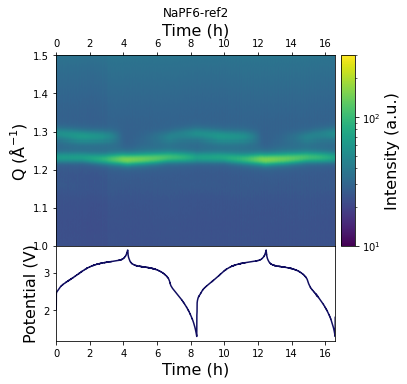

In [71]:
# Details for plotting
X, Y = np.meshgrid(Qs, d_time)

gs = mpl.gridspec.GridSpec(4, 1)

# Heatmap
fig1 = plt.figure(figsize=(5,7))
ax1 = fig1.add_subplot(gs[0:2])

# Echem plot
ax2 = fig1.add_subplot(gs[2])


# Details heatmap
pcm = ax1.pcolormesh(Y, X, W.T,
                    norm=LogNorm(vmin=10, vmax=300), #change the vmin,vmax values to get better visualization
                    cmap='viridis',
                    rasterized=True
                    )
ax1.set_title("NaPF6-ref2") # Change the title
ax1.set_ylabel(r'Q ($\rm \AA^{-1}$)', fontsize=f_size)
ax1.xaxis.tick_top()
ax1.set_ylim((two_theta_min, two_theta_max))
ax1.set_xlim(np.min(d_time), 16.6) #NOTE: the xlim for the diffraction plot and echem plot should be set to the same value! Either you specify a value or use np.max(d_time)
ax1.set_ylabel(r'Q ($\rm \AA^{-1}$)', fontsize=f_size)
ax1.set_xlabel(r'Time (h)', fontsize=f_size)
ax1.xaxis.set_label_position('top')

cbaxis = inset_axes(ax1, width='5%', height='100%', loc='right', borderpad=-2)
cbar = fig1.colorbar(pcm, cax=cbaxis)
cbar.set_label(r'Intensity (a.u.)', fontsize=f_size) 

# Details echem plot
ax2.plot(echem[:,0]/3600, echem[:,1], color='#110e61')
ax2.set_xlim(np.min(d_time), 16.6) #NOTE: the xlim for the diffraction plot and echem plot should be set to the same value! Either you specify a value or use np.max(d_time)
ax2.set_xlabel(r'Time (h)', fontsize=f_size)
ax2.set_ylabel(r"Potential (V)", fontsize=f_size)

plt.subplots_adjust(hspace=0)
# Saving the plot (provide the path and file name)
plt.savefig(r'C:\Users\idani183\Desktop\PhD\Analysis\DanMAX_March_2023\DiffractionData\NaPF6-ref2\\NaPF6-ref2_zoom.png', dpi=600, transparent=True, bbox_inches='tight')